# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [17]:
# 🔓
l = 50 / 100
r = 12.5 / 100

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the scooter (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [3]:
# 🔓
def draw_scooter(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)], 
        [sin(theta),  cos(theta)]
    ])

    # Left pad
    corners = [[0, 0], [-r, l/2], [r, l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="red", zorder=10)

    # Right pad
    corners = [[0, 0], [r, -l/2], [-r, -l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="red", zorder=10)
    
    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-r], [-l/2]] + translation 
    wheel_left_xy_end = rotation @ [[r], [-l/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-r], [l/2]] + translation
    wheel_right_xy_end = rotation @ [[r], [l/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5, zorder=20)

    # Forward marker
    xm, ym = rotation @ array([0.5, 0]) + array([x, y])
    plot([xm], [ym], "o", color="green")


🧩 Represent the scooter when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

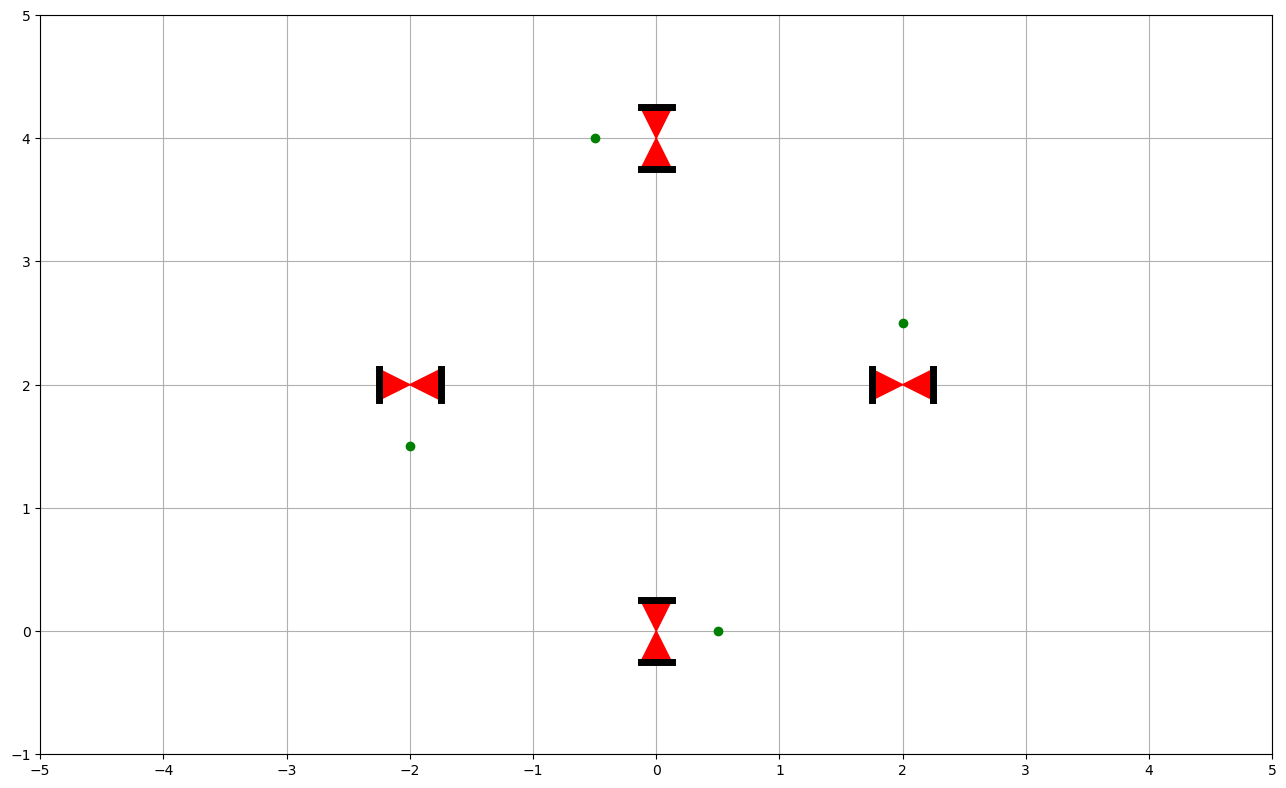

In [5]:
# 🔓
draw_arena(-5, 5, -1, 5)
draw_scooter(0, 0, 0)
draw_scooter(2, 2, pi/2)
draw_scooter(0, 4, pi)
draw_scooter(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the scooter).
We also assume that the scooter fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

🔓
$$
\begin{array}{rcl}
\dot{x} &=& r  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& r  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& r  \frac{\omega_r - \omega_l}{\ell} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

🔓 The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

🔓 When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 (\ell/r)  \theta^2$, we end up with $\dot{\theta}(t) = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [7]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [8]:
# 🔓
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = r * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = r * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = r * (omega_r - omega_l) / l
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the scooter dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [9]:
# 🔓
results = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

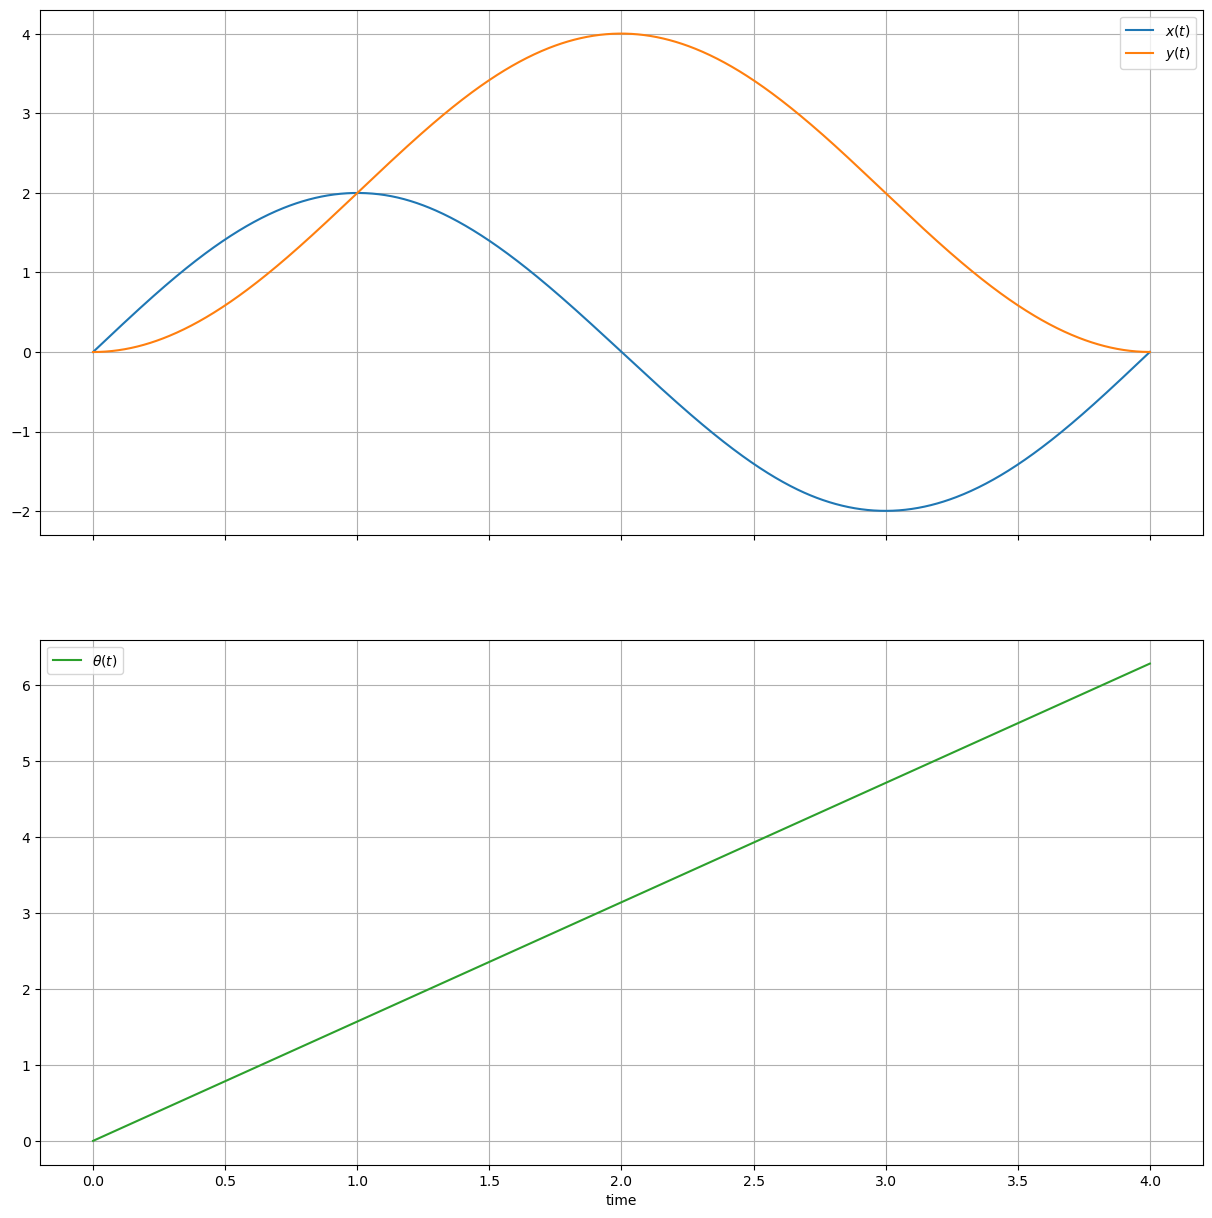

In [10]:
# 🔓
t = linspace(0.0, 4.0, 1000)
x, y, theta = results["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

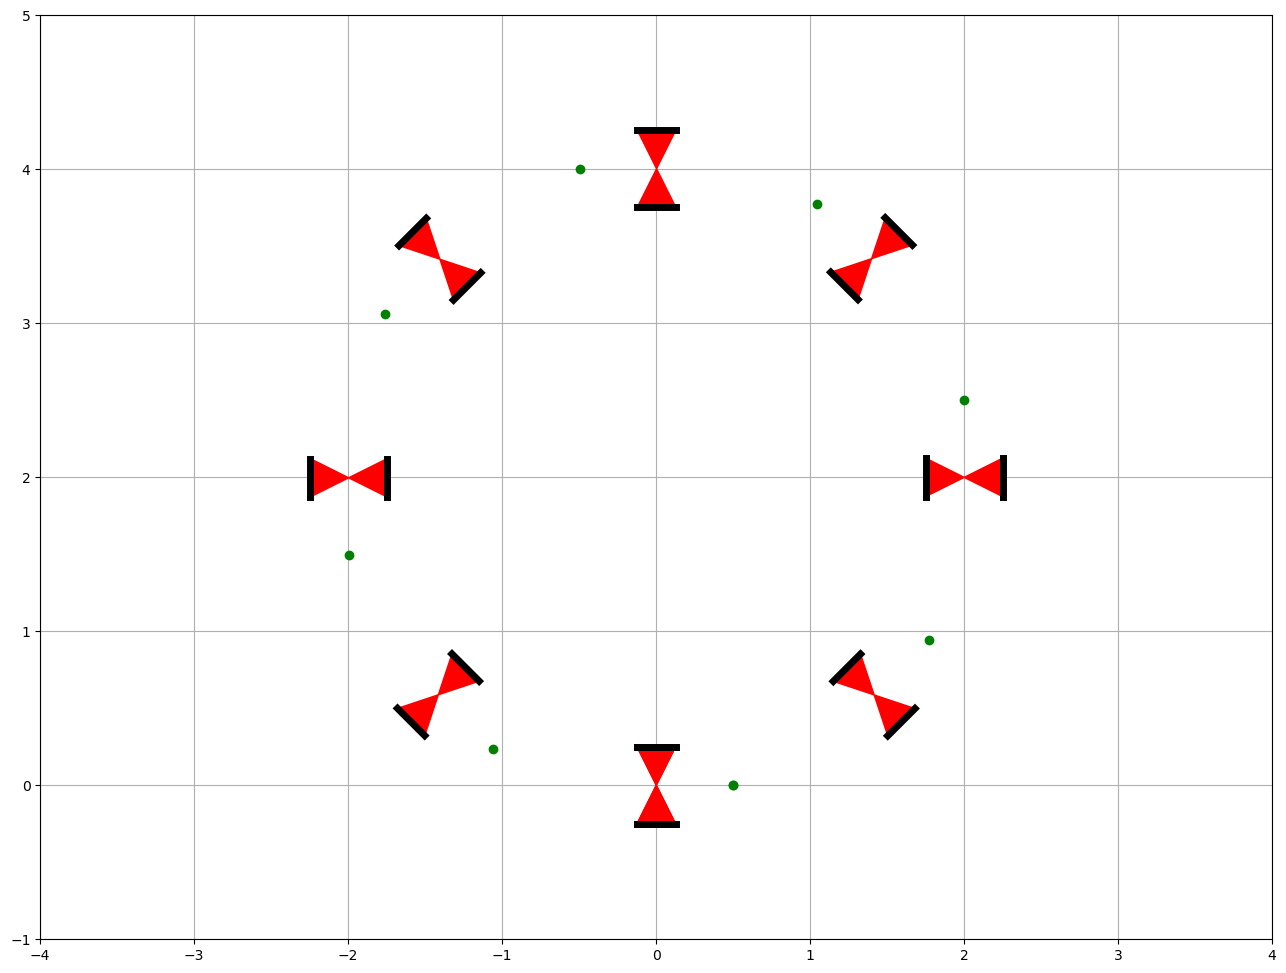

In [11]:
# 🔓
t = linspace(0.0, 4.0, 4*2+1)
sol_t = results["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_scooter(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

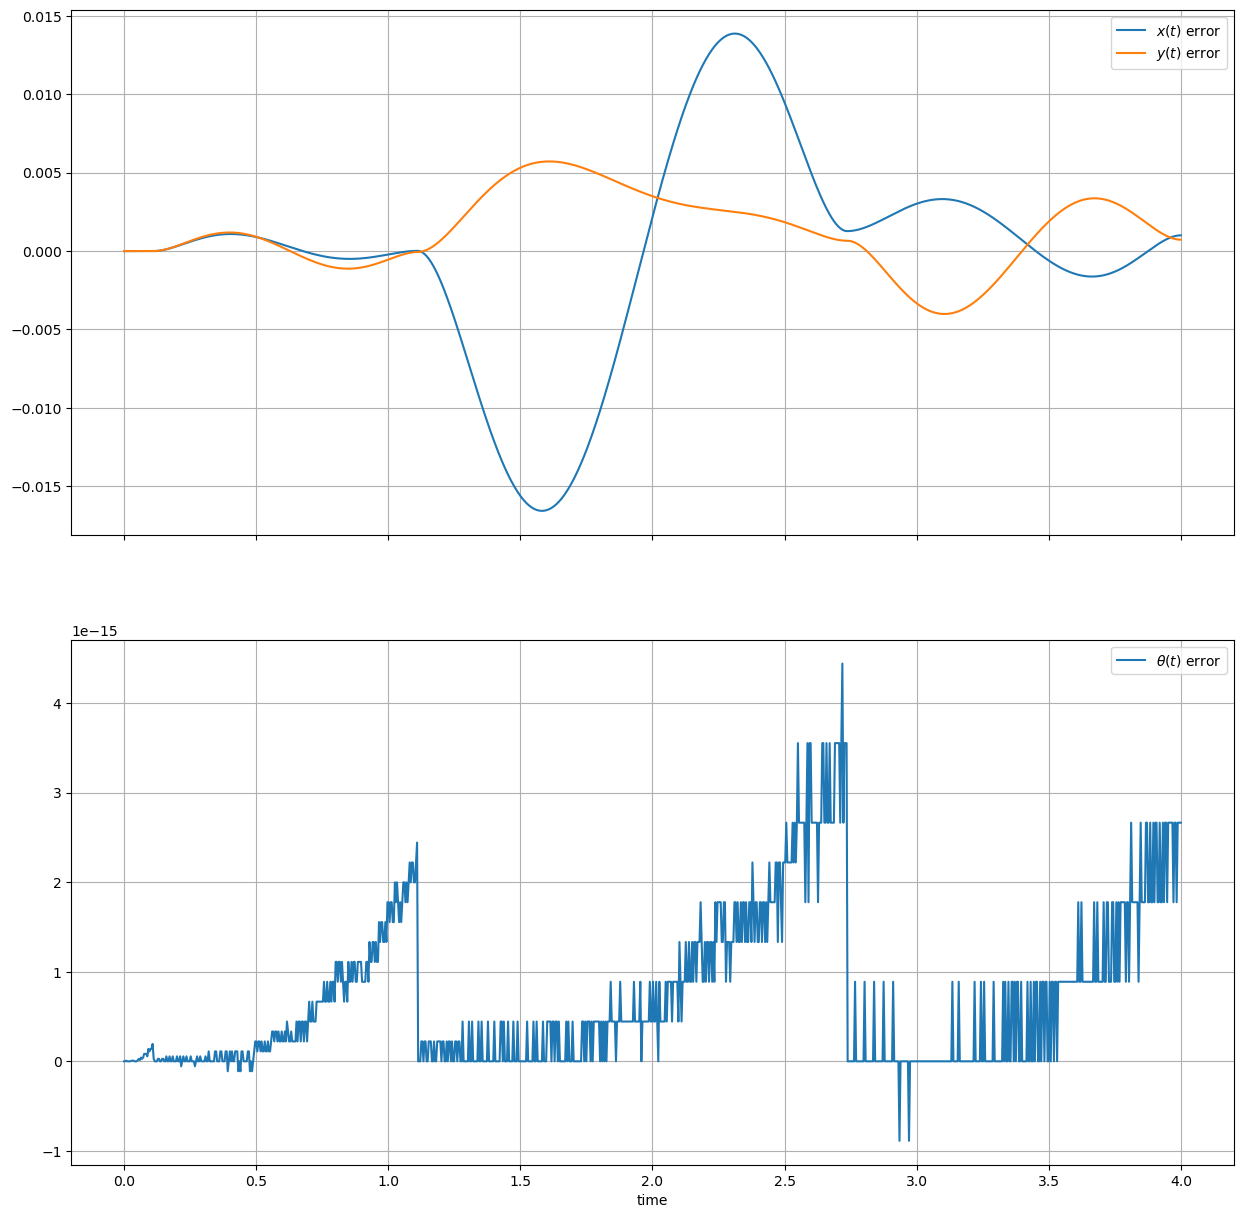

In [12]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = results["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

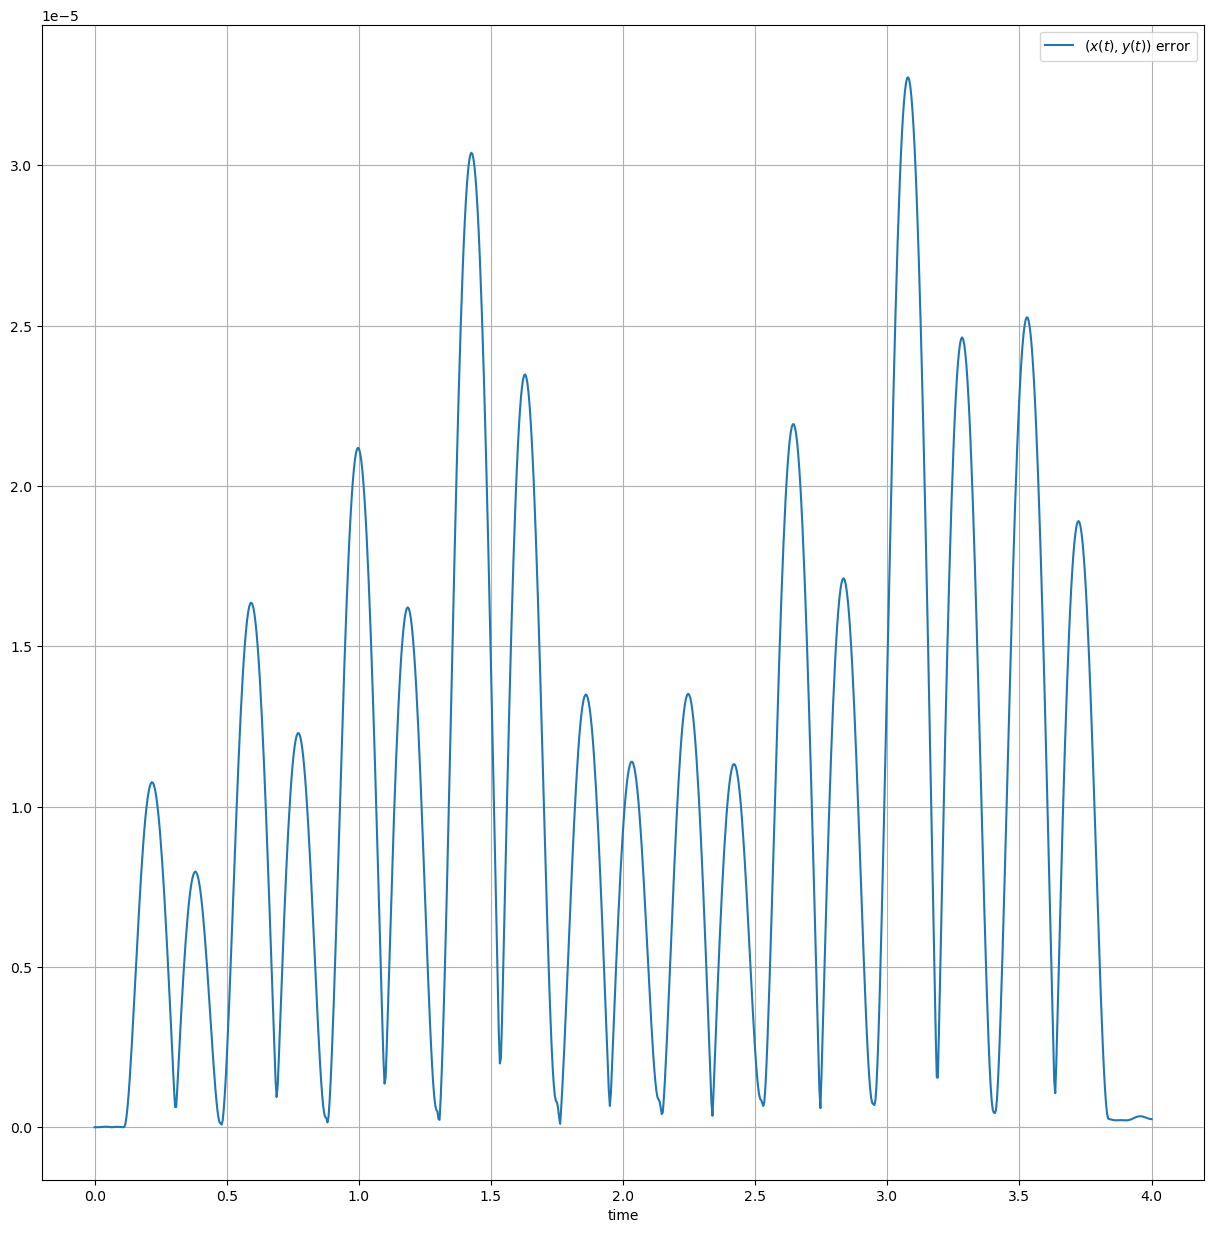

In [13]:
results = solve_ivp(
    fun=fun, 
    t_span=(0.0, 4.0), 
    y0=[0.0, 0.0, 0.0], 
    rtol=1e-6, 
    atol=1e-6, 
    dense_output=True
)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = results["sol"](t)
figure(figsize=(15, 15))
grid(True)
plot(t , sqrt((x_t - 2*sin(2*pi*t/4))**2 + (y_t + 2*cos(2*pi*t/4) - 2)**2) , label="$(x(t), y(t))$ error")
legend()
grid(True)
xlabel("time")
pass

Step 2 - Control Implementation
===============================

Time dependent inputs
---------------------

We are going to simulate the case of the scooter controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 
We want a simulation lasting 5 seconds with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{rl}
           (1 - \ell/4) \pi / r & \mbox{when $t \leq 1 \,  \mathrm{s}$ or  $t \geq 3 \,  \mathrm{s}$,} \\
           (1 + \ell/4) \pi / r & \mbox{otherwise.}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{rl}
           (1 + \ell/4) \pi / r & \mbox{when $t \leq 1 \,  \mathrm{s}$ or $t \geq 3 \,  \mathrm{s}$,} \\
           (1 - \ell/4) \pi / r & \mbox{otherwise.}
       \end{array}
    \right.
$$

##### 🧩 Provide the new definition of `omega`

In [18]:
l = 50 / 100
r = 12.5 / 100

In [19]:
def omega(t, xytheta):
    if t <= 1 or t >= 3:
        omega_l = (1 - l/4) * pi / r
        omega_r = (1 + l/4) * pi / r
    else:
        omega_l = (1 + l/4) * pi / r
        omega_r = (1 - l/4) * pi / r
    return array([omega_l, omega_r])

##### 🧩 Make a simulation of 4 sec of the robot with the previous input. Use the `rtol` and `atol` that used to guarantee a precision of $1 \, \mathrm{mm}$ and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** It is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`.  

In [20]:
resultat = solve_ivp(fun=fun,y0=[0,0,0],t_span=[0,4], rtol=1e-6, atol=1e-12, dense_output=True)

🧩 Use the simulation results to display the robot location every 0.5 seconds.

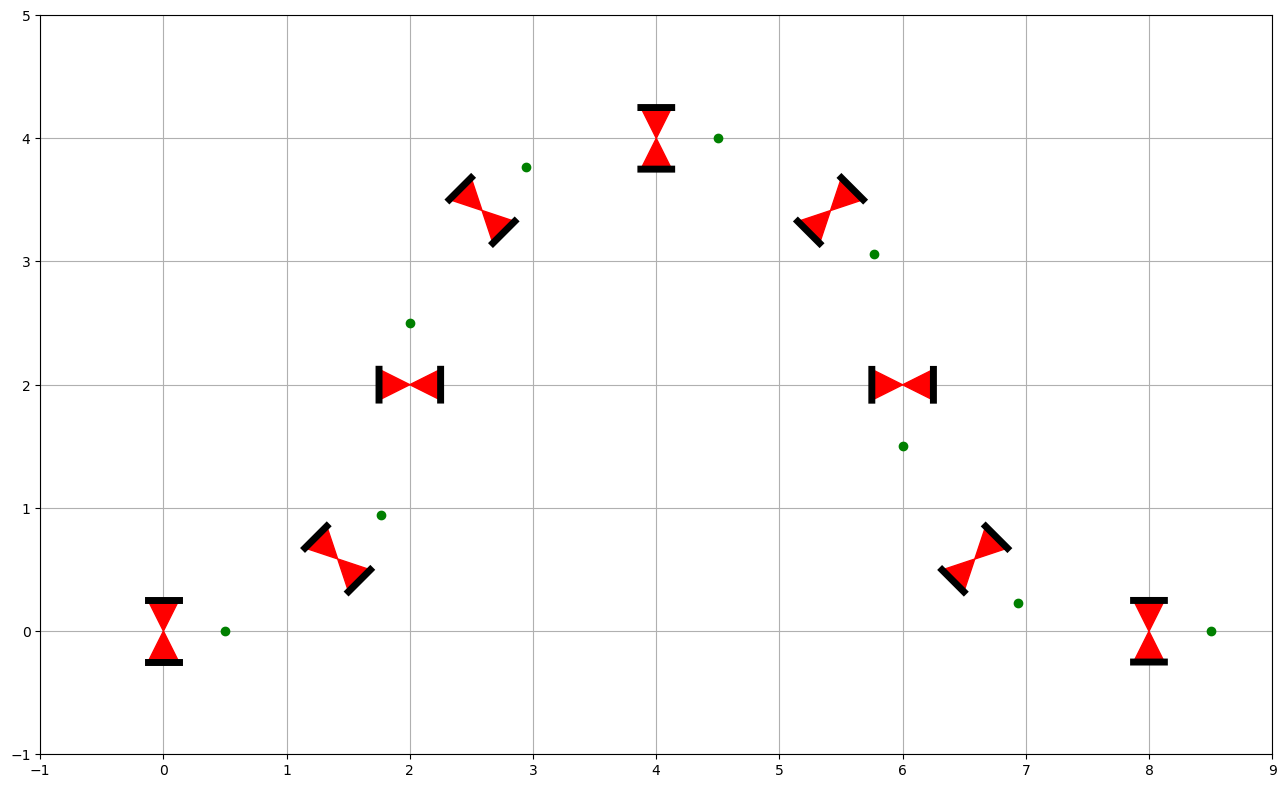

In [21]:
count = 0.5
t = arange(0,4+count,count)
sol_t = resultat["sol"](t)
draw_arena(-1, 9, -1, 5)
for x, y, theta in sol_t.T:
    draw_scooter(x, y, theta)

## Analysis of the system at rest

### Equilibrium

##### 🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the scooter kinematic model.

En supposoant que Xe=(0,0,0) est un point d'équilibre, on a: 
$$
\begin{array}{rcl}
\dot{\theta} =r  \frac{\omega_r - \omega_l}{l} =0\\
\dot{x} =r  \frac{\omega_l + \omega_r}{2}=0\\ 
\dot{y} =0 \qquad
\end{array}
$$

$$
\begin{array}{rcl}
donc \qquad \omega_l + \omega_r=0  \qquad et  donc \qquad \omega_l - \omega_r=0 \qquad
\end{array}
$$

$$
\begin{array}{rcl}
d'où
\\\omega_l = \omega_r=0\\
\end{array}
$$

##### 🧩 Show that for any other $\omega_e$, the system has no equilibrium.

En supposant que le systeme admet un point d'equilibre Xe. 
Donc $\dot{x}=\dot{y}=\dot{\theta}=0$ ,donc :
$$
\begin{array}{rcl}
\dot{\theta} =r  \frac{\omega_r - \omega_l}{l} =0\\
\dot{x} =r  \frac{\omega_l + \omega_r}{2}Cos({\theta})=0\\ 
\dot{y} =r  \frac{\omega_l + \omega_r}{2}Sin({\theta})=0 \qquad
\end{array}
$$
on se retrouve avec 
$$
\begin{array}{rcl}
{\omega_l} = {\omega_r} et \qquad \omega_l=- \omega_r \qquad
\end{array}
$$
On a $\dot{\theta}=0$, on conclut que quelque soit  ${\theta}$ on a ${\omega_l} = {\omega_r} =0 $

 Donc le systeme n'admet pas de point d'equilibre si $\omega \neq \omega_e$

##### 🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

If $$ω = ω_{e}$$ we have, $\dot x = 0$, $\dot y = 0$ and $\dot \theta = 0 ∀X_e$. Hence, $X_e$ is an equilibrium $∀ X_e ∈ \mathbb{R}$

### Linearized System Model


Let $\omega = \omega_e$ and $X_e = (0,0,0)$. Let us introduce the the error variable $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$ and $\Delta \omega = \omega - \omega_e$.

##### 🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$).

Pour linéariser la dynamique du scooter autour de $X_e = (0,0,0)$.
Le système originel est:
The original nonlinear system is:
\[
\begin{aligned}
\dot{x} &= r \frac{\omega_l + \omega_r}{2} \cos \theta, \\
\dot{y} &= r \frac{\omega_l + \omega_r}{2} \sin \theta, \\
\dot{\theta} &= r \frac{\omega_r - \omega_l}{\ell}.
\end{aligned}
\]
Pour $θ = 0$, on développe cos et sin en premier ordre pour $ cosθ ≈ 1$ et $sin θ \approx \theta$ donc les équations deviennent:
\[
\begin{aligned}
\dot{x} &= r \frac{\omega_l + \omega_r}{2}, \\
\dot{y} &= r \frac{\omega_l + \omega_r}{2} \theta, \\
\dot{\theta} &= r \frac{\omega_r - \omega_l}{\ell}.
\end{aligned}
\]

Puisque $X_e = (0,0,0)$ et $ω_e = 0$ on a:$ΔX = X$ et $Δω = ω$.

Ceci peut être écrit sous forme matricielle: $\dot{\Delta X} = A \Delta X + B \Delta \omega$


On a: 

\begin{aligned}
\begin{pmatrix}
\dot{x} \\
\dot{y} \\
\dot{\theta}
\end{pmatrix}
&=
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & \frac{r}{2} (\omega_l + \omega_r) \\
0 & 0 & 0
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
\theta
\end{pmatrix}
+
\begin{pmatrix}
\frac{r}{2} & \frac{r}{2} \\
0 & 0 \\
-\frac{r}{\ell} & \frac{r}{\ell}
\end{pmatrix}
\begin{pmatrix}
\omega_l \\
\omega_r
\end{pmatrix}.
\end{aligned}
\

Donc les matrices $A$ and $B$ sont:

$A = \begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{pmatrix}$
$B = \begin{pmatrix}
\frac{r}{2} & \frac{r}{2} \\
0 & 0 \\
-\frac{r}{\ell} & \frac{r}{\ell}
\end{pmatrix}$

D'où la linéarisation est:

$\dot{\Delta X} = A \Delta X + B \Delta \omega$,

où: 
$A = \begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{pmatrix}$
$B = \begin{pmatrix}
\frac{r}{2} & \frac{r}{2} \\
0 & 0 \\
-\frac{r}{\ell} & \frac{r}{\ell}
\end{pmatrix}$

*

### Stability of the linearized system

Non, car pour avoir cette stabilité il faut que les valeurs propres de $A$ soient strictement négatives. En effet, dans ce cas où $\Delta \omega$=(0,0), on a $\dot X = A.X$ et $A$ a trois valeurs propres nulles.

##### 🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

Initialement, lorsque 𝜔=𝜔𝑒, cela signifie que le système ne change pas au fil du temps et reste dans sa position initiale X0. Ainsi, pour tout 𝑡>0, 𝑋(𝑡)=𝑋0.

Si X0≠(0,0,0), alors le système n'est pas en position d'équilibre. Le système évoluera mais ne reviendra jamais à sa position d'origine, qui est l'origine du système. 

Par conséquent, le système initial n'est pas attractif, même localement, et ne possède donc pas de point d'équilibre asymptotiquement stable. Les solutions du système ne convergent pas vers l'origine, même lorsque le temps tend vers l'infini.

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:

$$
\frac{\Delta X}{dt} = A \Delta X + B\Delta u
$$

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

Pour w=(w1,w1) où w1!=0 on aura 
\begin{aligned}
\dot{x} &= r \frac{\omega_1 + \omega_1}{2} = r \omega_1, \\
\dot{y} &= r \frac{\omega_1 + \omega_1}{2} \theta = r \omega_1 \theta_0 = 0, \\
\dot{\theta} &= r \frac{\omega_1 - \omega_1}{\ell} = 0.
\end{aligned}
Donc : Le système avancera dans la droite suivant (OX) jusqu'à atteindre Xe =(0,0,0)*

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

Pour déterminer s'il existe une trajectoire admissible qui commence par l'état $X_0 = (0, 2, 0)$ et se termine à l'origine $(0, 0, 0)$ pour le système linéarisé, nous analysons le système simplifié :

$$
\dot{\Delta X} = B \Delta u,
$$

où

$$
B = \begin{pmatrix}
\frac{r}{2} & \frac{r}{2} \\
0 & 0 \\
-\frac{r}{\ell} & \frac{r}{\ell}
\end{pmatrix}.
$$

Les équations d'état sont :

$$
\begin{cases}
\dot{x} = \frac{r}{2} (\Delta \omega_l + \Delta \omega_r), \\
\dot{y} = 0, \\
\dot{\theta} = \frac{r}{\ell} (\Delta \omega_r - \Delta \omega_l).
\end{cases}
$$

Étant donné $X_0 = (0, 2, 0)$ :

 $\dot{y} = 0 \implies y = 2$.
On ne pourra alors pas changer la position vers (0,0,0)

##### 🧩 Is the linearized system controllable?

Puisque A=0 Donc la matrice de contrôlabilité $C$=[$B$ $AB$ $A²B$]= [$B$ $0$ $0$]
Le rang de la matrice C est celui de B qui est de 2 (ligne 1 et 3 dépendantes).
Alors, on aura pas la contrôlabilité du système

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

##### 🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

On a:  $X_R(t) = (vt, 0, \theta_R(t))$ 

Alors: $y_R(t) = 0$ (constant) $\implies \dot y_R(t) =0 \implies \frac{r}{2} (ω_r + ω_l) sinθ = 0$

Puisque $ω_r + ω_l 0 $ ne peut pas être vrai (sinon $x_R(t) = 0$), on obtient $sinθ = 0$ d'où $θ = k \pi$ mais \theta est constant dans ce cas (sinon le système sera objet d'une variation de ${\theta}$ ce qui va causer que $\dot{\theta}(t)\neq 0$ )

Ceci implique que $\cos \theta \in \{-1, 1\}$ d'où

$
\dot{x}_R(t) = \frac{r}{2}(\omega_r + \omega_l)
$

ou

$
\dot{x}_R(t) = -\frac{r}{2}(\omega_r + \omega_l)
$

Or $\dotθ(t) = 0$ donc $ω_r = ω_l = $

d'où $ω_r = ω_l = +- \frac{v}{r}$

On a donc 2 cas:

1. $X_R(t) = (vt ,0, 0)$ avec $\omega_R(t)=(\frac{v}{r},\frac{v}{r})$
1. $X_R(t) = (vt ,0, \pi)$ with a reference control $\omega_R(t)=(-\frac{v}{r},-\frac{v}{r})$

### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

##### 🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

$\Delta X(t) = X(t) - X_R(t) = (x(t)-vt, y(t), θ(t)) $ et
$\Delta \omega(t) = \omega(t) - \omega_R(t) =(\omega_l(t)-v/r, \omega_r(t) - v/r) $
$$
\frac{\Delta X}{dt} = A \Delta X + B\Delta u
$$
$$
  A = \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & v \\
      0 & 0 & 0
  \end{bmatrix}
$$

et 

$$
   B=\begin{bmatrix}
    \frac r2 & \frac r2  \\ 0 & 0 \\ -\frac rl & \frac rl
  \end{bmatrix}
$$

##### 🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

Pour $\Delta\omega(t)=0$ le système devient:
$$
\frac{\Delta X}{dt} = A \Delta X 
$$
Or la matrice $A$ est triangulairee, donc les valeurs propres sont $(0, 0, 0)$ qui sont non négatives. Le système n'est donc pas asymptotiquement stable

##### 🧩 Is the system attractive, with $\Delta\omega(t)=0$?

Si $\Delta\omega(t)=0$, le système devient:

$$\frac{\Delta X}{dt} = A \Delta X $$

Puisque $A$ n'est pas la matrice nulle, la solution de l'équation différentielle est toujours non nulle. L'erreur $ΔX$ est toujours non nulle.

Alors le système ne revient jamais à sa position d'équilibre, d'où le système n'est pas attractive.

On peut aussi le voir d'après la question précédente, on a vu que le système n'est pas asymptotiquement stable, donc ne revient pas à sa position d'équilibre d'où la non-attractivité

##### 🧩 Show that the linearized system is controllable.

$$\mathcal{C} = \left[ \begin{array}{ccc|cc|cc}
    \frac{r}{2} & \frac{r}{2} & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & \frac{rv}{2} & \frac{rv}{2} & 0 & 0 & 0 \\
    -\frac{r}{\ell} & \frac{r}{\ell} & 0 & 0 & 0 & 0 & 0
\end{array} \right]$$
C est de rang 3. Donc, le système est contrôlable

### Linearized system implementation

In the sequel, we will use $v=25 \mbox{ km/h}$.

##### 🧩 Implement and print the matrices $A$ and $B$

In [25]:
v = 25 / 3.6
A = array([[0, 0, 0], [0, 0, v], [0, 0, 0]])
B = array([[r/2, r/2], [0, 0], [-r/l, r/l]])
print(A)
print(B)

[[0.         0.         0.        ]
 [0.         0.         6.94444444]
 [0.         0.         0.        ]]
[[ 0.0625  0.0625]
 [ 0.      0.    ]
 [-0.25    0.25  ]]


The linear model has to be fed with some $\Delta\omega$ input. Like for the nonlinear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we set:

In [26]:
def deltaOmega(t, deltaX):
    return array([0, 0, 0])

##### 🧩 Using this function `deltaOmega`, define a function `lin_fun` that computes $d{\Delta X}/dt$ given the arguments `t` and `deltaX`$.

In [27]:
def lin_fun(t, deltaX):
    return A @ deltaX + B @ deltaOmega(t, deltaX)

### Controller Design on the linearized system

##### 🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. 

For this question, we will chose 3 real poles close to -1.0.

Then, print the poles of the closed-loop system

$$
\frac{d\Delta X}{dt}= A \Delta X + B\Delta\omega
\; \mbox{ with } \;
\Delta\omega = -K \Delta X.
$$

In [28]:
poles = np.array([-1.01, -1.0, -1.02])

# Compute gain matrix
K = place_poles(A, B, poles).gain_matrix
print(K)
CL_poles = eigvals(A - B@K)
print("Poles of closed-loop system:", real(CL_poles))

[[ 8.07999995 -0.28665423 -3.9913835 ]
 [ 8.07999999  0.30086577  4.08861651]]
Poles of closed-loop system: [-1.01 -1.02 -1.  ]


##### 🧩 Simulate the linearized system during 20s, with the initial condition $\Delta X(0) = (0,2,0)$.

In [29]:
def deltaOmega(t,deltaX):
    return -K@deltaX
r = solve_ivp(fun=lin_fun,t_span=[0,20],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

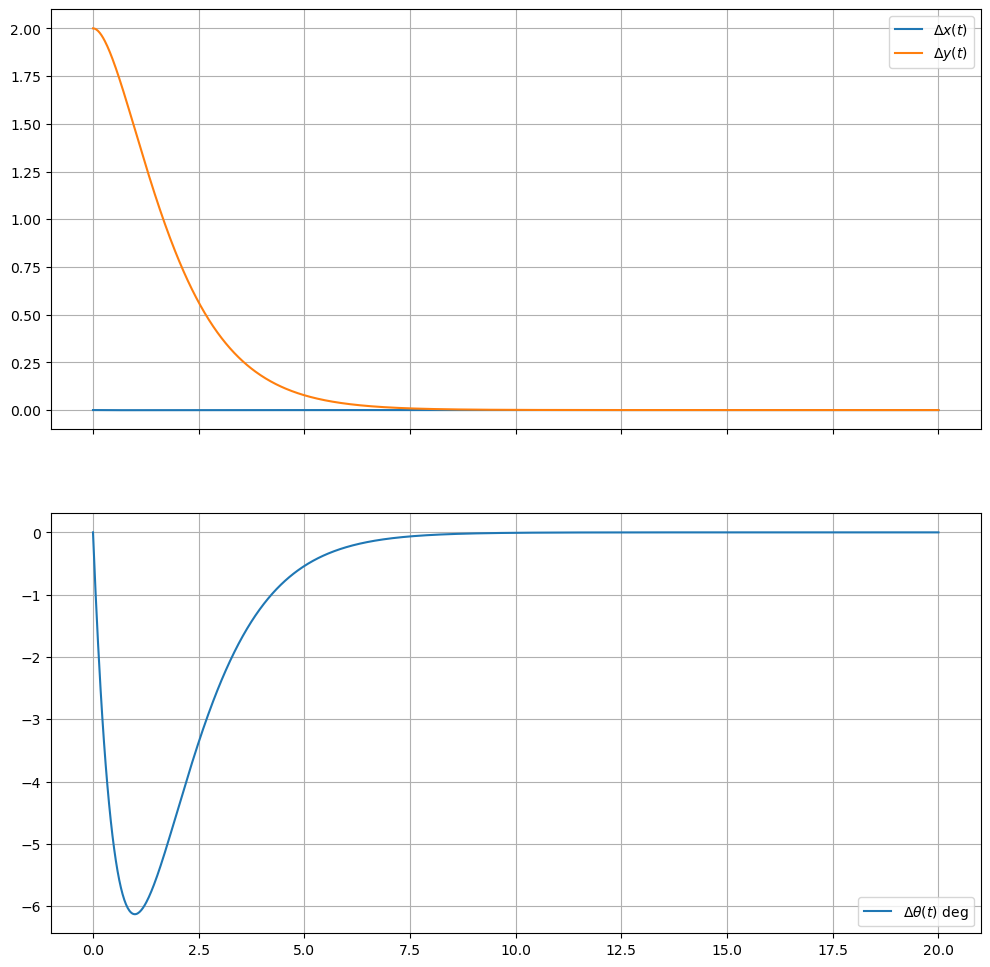

In [30]:
t = linspace(0.0,20, 1000)
dx, dy, dtheta = r["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()

##### 🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

Pour que le système maintienne une trajectoire linéaire, il est essentiel que l'erreur $\Delta\theta(t)$ soit faible, car $\theta$ détermine l'orientation du scooter.

##### 🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [31]:
d_x = r["sol"](t)
dOmega = -K@d_x
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]

##### 🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

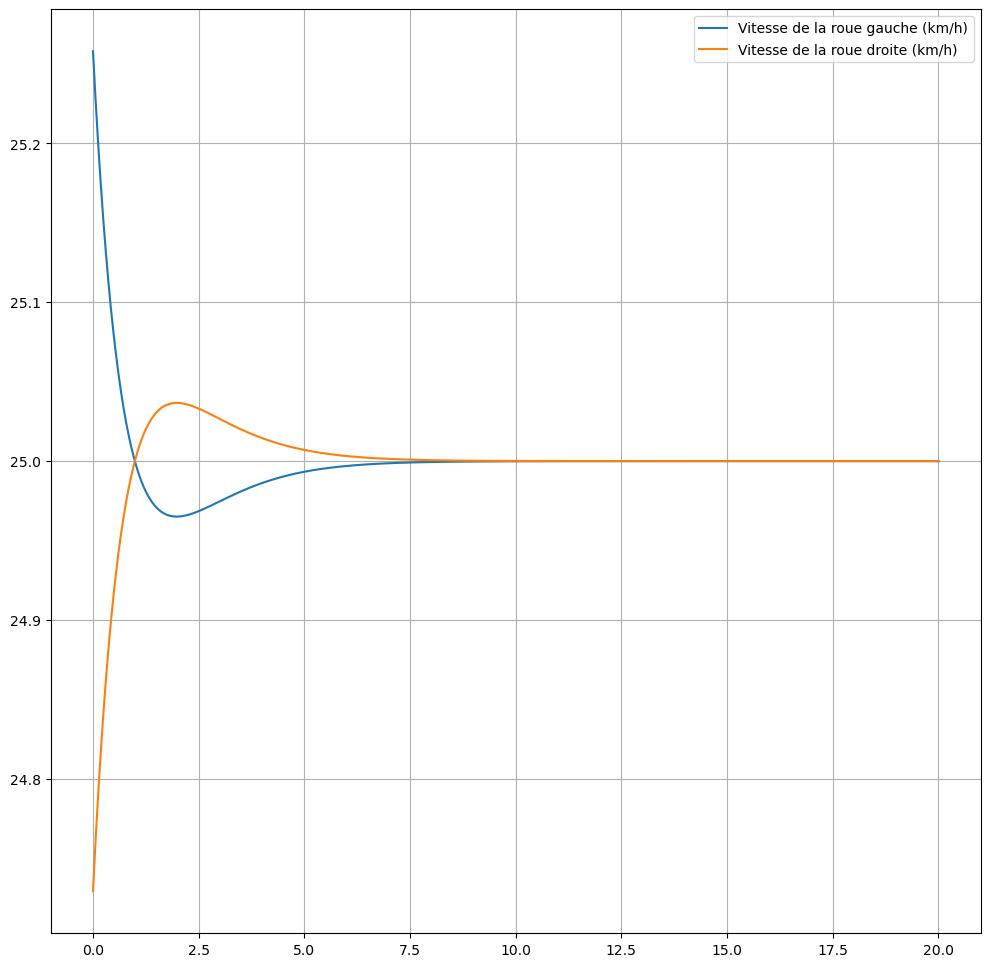

In [32]:
l = 50 / 100
r = 12.5 / 100
omega_l = dOmega_l +v/r
omega_r = dOmega_r +v/r

fig=figure(figsize=(12, 12))
plot(t,omega_l*r*3.6, label=r"Vitesse de la roue gauche (km/h)")
plot(t,omega_r*r*3.6, label=r"Vitesse de la roue droite (km/h)")
grid()
legend()

##### 🧩 Are these control values consistent with what the robot should do to cancel the error?

Au départ, le scooter était située avec une position en y>0. Pour tourner à droite et rejoindre l'axe Ox, la roue gauche devait tourner plus rapidement que la roue droite. Ensuite, les deux roues devaient progressivement ajuster leur vitesse pour converger vers 25 km/h afin de continuer sur une trajectoire linéaire.

###  Controller Tuning



##### 🧩 Tune the poles (and recompute the gain matrix) so that the actual location $(x, y)$ is within 10 cm of the desired location within 20 sec but the angle $\Delta \theta$ never exceeds $\pm 5 \, \mathrm{deg}$. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

In [24]:
pass

##### 🧩 Simulate the initial, nonlinear scooter model when the control law computed in the section "Controller Tuning" is applied. Check that the constraint given for the control law design still hold.

In [25]:
pass

##### 🧩 Display the first 5 seconds of this trajectory using a snapshot of the scooter in the plane every 0.25 second.

In [26]:
pass